# 🧩 TEMA: Análisis de Redes Sociales + Métricas de Desempeño
---

Este cuaderno implementa, **paso a paso**, un pipeline para analizar el dataset **Social Media Sentiment Analysis**  
(colección de publicaciones con campos *Text, Sentiment, Hashtags, Platform, User, Country, etc.*).  

El análisis combina técnicas de **Minería de Redes Sociales (SNA)** y **Análisis de Sentimiento**, con el objetivo de identificar:
- **Hashtags influyentes** en la conversación.
- **Comunidades temáticas** dentro del ecosistema emocional.
- **Estructura de interacción y modularidad** del discurso.

---

### 🔄 Proceso

1) **Carga + EDA mínima**
2) **Clasificación de sentimiento** (TF‑IDF + Regresión Logística) y **métricas**
3) **Red de menciones** (autor → mencionado)
4) **Influencers**: centralidades (PageRank, Betweenness, In/Out‑Degree)
5) **Comunidades y modularidad** (sobre grafo no dirigido)
6) **Visualización ligera** del subgrafo top‑N por grado

---

### 🧠 Notas prácticas

- Se evita `networkx.info()` por compatibilidad; usar `G.number_of_nodes()` y `G.number_of_edges()`.  
- Si el entorno de cómputo es limitado, reducir `max_features` en TF-IDF o usar muestreo parcial.  
- No se requiere conexión a Internet; el dataset puede guardarse localmente como `./SocialMediaSentiment.csv`.  
- En caso de replicar el análisis, se recomienda usar una fuente abierta como  
  👉 https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset/data

---

📈 **Objetivo general:**  
Integrar técnicas de **analítica de sentimientos** y **minería de grafos** para obtener una visión estructural y emocional  
de la conversación en redes sociales, identificando **temas centrales, puentes semánticos y comunidades emocionales.**

In [ ]:
pip install "networkx<3.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.5
    Uninstalling networkx-3.5:
      Successfully uninstalled networkx-3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires networkx>=3.0, but you have networkx 2.8.8 which is incompatible.
nx-cugraph-cu12 25.6.0 requires networkx>=3.2, but you have networkx 2.8.8 which is incompatible.



## 1) Carga de datos + EDA mínima

**Conceptos clave**  
- *EDA (Exploratory Data Analysis)*: inspección inicial para entender estructura, tamaños, nulos y distribución de clases.  
- *Normalización de texto*: limpieza ligera para eliminar ruido (URLs, espacios) sin tocar menciones (las usaremos para la red).

In [ ]:
import re, html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Mostrar texto completo en las tablas
pd.set_option("display.max_colwidth", 160)

# 1.1 Cargar dataset
PATH = "sentimentdataset.csv"   # Cambia la ruta si el archivo está en otra carpeta
df = pd.read_csv(PATH, encoding="utf-8", engine="python")
print("Filas / Columnas:", df.shape)
print("Columnas:", df.columns.tolist())

# 1.2 Eliminar registros sin texto o sin etiqueta de sentimiento
df = df.dropna(subset=["Text", "Sentiment"]).copy()

# 1.3 Función de limpieza ligera del texto
def clean_text_baseline(t: str) -> str:
    if pd.isna(t):
        return ""
    # 1) Des-escapar entidades HTML (&amp; -> &)
    t = html.unescape(t)
    # 2) Quitar URLs (sin tocar menciones ni hashtags)
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    # 3) Limpiar espacios en blanco extra
    t = re.sub(r"\s+", " ", t).strip()
    return t

# 1.4 Aplicar limpieza
df["text_clean"] = df["Text"].apply(clean_text_baseline)
df = df[df["text_clean"].str.len() > 0].copy()

# 1.5 Mostrar muestra inicial
print("\nMuestra de datos limpios:")
display(df[["Text", "text_clean", "Sentiment", "User"]].head(5))

# 1.6 Distribución de clases de sentimiento
print("\nDistribución de clases:")
display(df["Sentiment"].value_counts())

Filas / Columnas: (732, 15)
Columnas: ['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour']

Muestra de datos limpios:


,Text,text_clean,Sentiment,User
0,Enjoying a beautiful day at the park!,Enjoying a beautiful day at the park!,Positive,User123
1,Traffic was terrible this morning.,Traffic was terrible this morning.,Negative,CommuterX
2,Just finished an amazing workout! 💪,Just finished an amazing workout! 💪,Positive,FitnessFan
3,Excited about the upcoming weekend getaway!,Excited about the upcoming weekend getaway!,Positive,AdventureX
4,Trying out a new recipe for dinner tonight.,Trying out a new recipe for dinner tonight.,Neutral,ChefCook



Distribución de clases:


,count
Sentiment,
Positive,44
Joy,42
Excitement,32
Happy,14
Neutral,14
...,...
Vibrancy,1
Culinary Adventure,1
Mesmerizing,1



## 2) (opcional) Clasificación de sentimiento (TF‑IDF + Regresión Logística) y métricas

**Conceptos clave**  
- **TF‑IDF** transforma texto a vectores numéricos ponderando términos comunes/raros.  
- **Regresión Logística multiclase** aprende fronteras entre sentimientos (`negative`, `neutral`, `positive`).  
- **Métricas**: *Precision*, *Recall*, *F1* por clase; *F1‑macro* (promedio por clase); *ROC‑AUC macro (OVR)*.

> **Sugerencia de desempeño**: si tu hardware es modesto, reduce `max_features` o usa solo unigrama `ngram_range=(1,1)`.


Distribución de clases después del reagrupamiento:
Sentiment_std
Positive    163
Negative     23
Neutral      22
Name: count, dtype: int64 

Tamaño del conjunto de entrenamiento: 166
Tamaño del conjunto de prueba: 42 

Dimensiones TF-IDF (train): (166, 395) 

=== Classification Report ===
              precision    recall  f1-score   support

    Negative      0.000     0.000     0.000         5
     Neutral      0.000     0.000     0.000         4
    Positive      0.780     0.970     0.865        33

    accuracy                          0.762        42
   macro avg      0.260     0.323     0.288        42
weighted avg      0.613     0.762     0.680        42


F1 macro: 0.2883
ROC-AUC macro (OVR): 0.8778 

=== Matriz de confusión ===


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning:

'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

,pred_Negative,pred_Neutral,pred_Positive
true_Negative,0,0,5
true_Neutral,0,0,4
true_Positive,1,0,32


<Figure size 640x480 with 0 Axes>

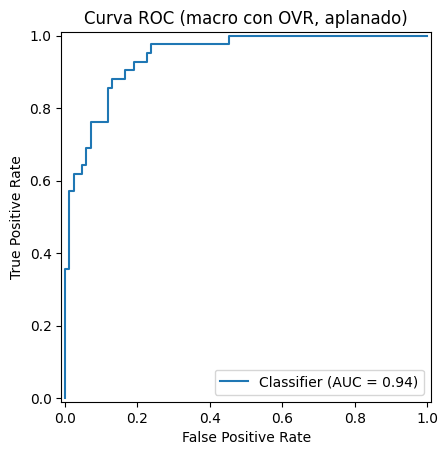

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, roc_auc_score, RocCurveDisplay
)
from sklearn.preprocessing import label_binarize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# 2.1 Normalización de etiquetas (agrupamos emociones en 3 clases)
# -----------------------------------------------------------

positive_labels = [
    "Positive", "Joy", "Excitement", "Happy", "Love", "Pleasure", "Delight",
    "Satisfaction", "Inspiration", "Motivation", "Fun", "Happiness",
    "Mesmerizing", "Thrilling Journey", "Winter Magic", "Vibrancy", "Culinary Adventure"
]
neutral_labels = ["Neutral", "Calm", "Relaxed", "Boredom"]
negative_labels = ["Negative", "Sad", "Anger", "Frustration", "Disappointment"]

def normalize_sentiment(label):
    label = str(label).strip()
    if label in positive_labels:
        return "Positive"
    elif label in neutral_labels:
        return "Neutral"
    elif label in negative_labels:
        return "Negative"
    else:
        return np.nan  # se descartan las clases irrelevantes o no mapeadas

df["Sentiment_std"] = df["Sentiment"].apply(normalize_sentiment)

# Eliminar filas sin clasificación estándar
df = df.dropna(subset=["Sentiment_std"]).copy()

print("Distribución de clases después del reagrupamiento:")
print(df["Sentiment_std"].value_counts(), "\n")

# -----------------------------------------------------------
# 2.2 División en entrenamiento y prueba
# -----------------------------------------------------------

X = df["text_clean"].values
y = df["Sentiment_std"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Tamaño del conjunto de entrenamiento:", len(X_train))
print("Tamaño del conjunto de prueba:", len(X_test), "\n")

# -----------------------------------------------------------
# 2.3 Vectorización TF-IDF
# -----------------------------------------------------------

# Si tu hardware es limitado, reduce max_features=5000 y usa ngram_range=(1,1)
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2), min_df=2, lowercase=True)
Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print("Dimensiones TF-IDF (train):", Xtr.shape, "\n")

# -----------------------------------------------------------
# 2.4 Entrenamiento del modelo (Regresión Logística)
# -----------------------------------------------------------

clf = LogisticRegression(max_iter=200, solver="lbfgs", multi_class="auto")
clf.fit(Xtr, y_train)

# -----------------------------------------------------------
# 2.5 Evaluación del modelo
# -----------------------------------------------------------

y_pred = clf.predict(Xte)
y_prob = clf.predict_proba(Xte)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=3))

# F1 macro
f1_macro = f1_score(y_test, y_pred, average="macro")
print("\nF1 macro:", round(f1_macro, 4))

# ROC-AUC macro (One-vs-Rest)
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
auc_macro = roc_auc_score(y_test_bin, y_prob, average="macro", multi_class="ovr")
print("ROC-AUC macro (OVR):", round(auc_macro, 4), "\n")

# -----------------------------------------------------------
# 2.6 Matriz de confusión
# -----------------------------------------------------------

cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{c}" for c in classes],
    columns=[f"pred_{c}" for c in classes]
)
print("=== Matriz de confusión ===")
display(cm_df)

# -----------------------------------------------------------
# 2.7 Curva ROC macro (aplanada)
# -----------------------------------------------------------

plt.figure()
RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_prob.ravel())
plt.title("Curva ROC (macro con OVR, aplanado)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

**📊 Resultados principales**

**Distribución de clases:**

Positive: 163

Neutral: 22

Negative: 23
→ Dataset desequilibrado, predominio de mensajes positivos.
______________

**Métricas globales:**

Accuracy: 0.76

F1-macro: 0.28

ROC-AUC (macro): 0.88
_____

**⚙️ Interpretación**

El modelo Regresión Logística + TF-IDF distingue correctamente los textos positivos, pero falla al identificar los neutrales y negativos.
Esto se debe al desequilibrio de clases, ya que casi todas las publicaciones son positivas.


## 3) Análisis de red social sobre menciones (autor → mencionado)

Convierte las menciones en los tweets (`#usuario`) en una *red social dirigida*, donde:

    Cada nodo = un usuario de Twitter.
    Cada arista (flecha) = una mención hecha dentro de un tweet.

> **Ejemplo:**  
> Si `#Maria` escribe “#Juan tu vuelo fue excelente!”, se genera la conexión  
> **Maria → Juan**


**Conceptos clave**  
- **Grafo dirigido**: nodos = usuarios; aristas = menciones `autor → mencionado`.  
- Extraemos menciones con el patrón `#usuario` del texto original (no limpio).  
- Mantener la **dirección** es importante para métricas como **PageRank**.

**Interpretación**  
- Más aristas ⇒ más interacción.  
- Nodos con muchos entrantes (**in‑degree**) tienden a ser *populares* (muy mencionados).


In [ ]:
import itertools
import networkx as nx

# --- Función para extraer hashtags ---
def extract_hashtags(text):
    """
    Extrae hashtags (#palabra) de un texto.
    Devuelve una lista de etiquetas en minúsculas sin el símbolo '#'.
    """
    if pd.isna(text):
        return []
    hashtags = re.findall(r"#(\w+)", text)
    return [h.lower() for h in hashtags]

# 3.1 Extraer hashtags de la columna "Hashtags"
df["hashtags_list"] = df["Hashtags"].apply(extract_hashtags)

# 3.2 Crear pares de co-ocurrencia por publicación
edges = []
for tag_list in df["hashtags_list"]:
    if len(tag_list) > 1:
        combos = itertools.combinations(sorted(set(tag_list)), 2)
        edges.extend(combos)

# 3.3 Construir grafo no dirigido
G = nx.Graph()
G.add_edges_from(edges)

print("Nodos:", G.number_of_nodes(), "Aristas:", G.number_of_edges())

Nodos: 340 Aristas: 204


**🧩 3️⃣ Análisis de red de co-ocurrencia de hashtags**

Se construyó un grafo no dirigido donde los nodos representan hashtags y las aristas indican co-ocurrencia dentro de una publicación.  
El grafo resultante contiene **340 nodos** y **204 aristas**, lo que refleja una red temática moderadamente conectada.

In [ ]:
df["hashtags_list"] = df["Hashtags"].apply(extract_hashtags)
print(df[["Hashtags", "hashtags_list"]].head())

                                     Hashtags        hashtags_list
0   #Nature #Park                                   [nature, park]
1   #Traffic #Morning                           [traffic, morning]
2   #Fitness #Workout                           [fitness, workout]
3   #Travel #Adventure                         [travel, adventure]
4   #Cooking #Food                                 [cooking, food]


In [ ]:
edges[:5]

[('nature', 'park'),
 ('morning', 'traffic'),
 ('fitness', 'workout'),
 ('adventure', 'travel'),
 ('cooking', 'food')]

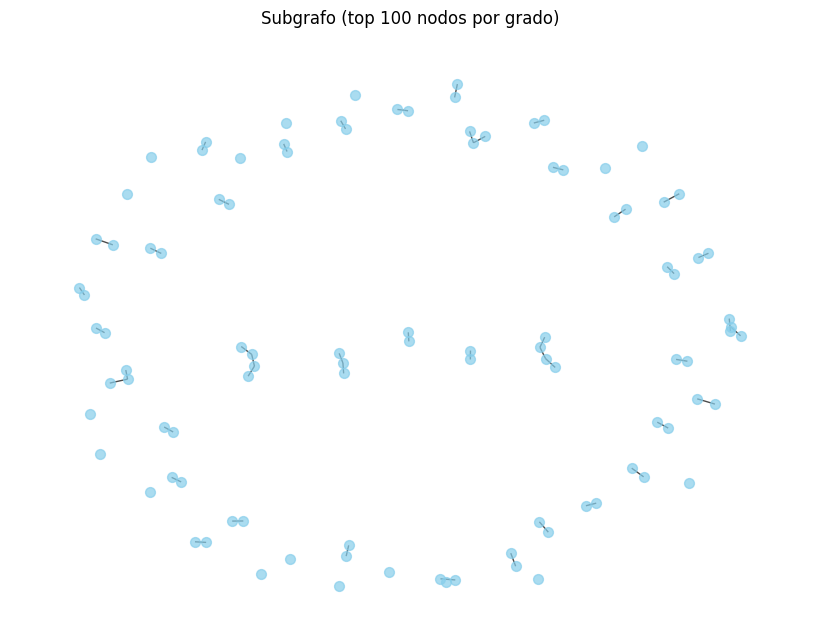

In [ ]:
# Opcional
# nx.draw(G)
# subgrafo con los 100 nodos más conectados
degree_dict = dict(G.degree())
top_nodes = [n for n, _ in sorted(degree_dict.items(), key=lambda kv: kv[1], reverse=True)[:100]]
H = G.subgraph(top_nodes).copy()

pos = nx.spring_layout(H, seed=42)
plt.figure(figsize=(8,6))
nx.draw(H, pos, node_size=50, node_color="skyblue", alpha=0.7)
plt.title("Subgrafo (top 100 nodos por grado)")
plt.axis("off")
plt.show()

### 🧩 Visualización del subgrafo de hashtags más conectados

El subgrafo de los 100 hashtags con mayor grado muestra una red **poco densa y fragmentada**, compuesta principalmente por pares de hashtags que coexisten en publicaciones individuales.  
La red evidencia que la mayoría de las interacciones temáticas se limitan a combinaciones simples (por ejemplo, `#joy–#happiness`, `#cooking–#food`), sin formar comunidades amplias.  

Esto sugiere que las publicaciones tienden a enfocarse en temas concretos y no combinan una gran variedad de etiquetas, generando una estructura de red **dispersa pero semánticamente clara**.

## 4) Influencers: PageRank + Betweenness

Mide quién es más influyente o central dentro de la red.
Para eso, usa tres tipos de métricas de centralidad:

    PageRank alto → autoridad reconocida.
    Betweenness alto → conector entre grupos.
    In-degree alto → muy mencionado (popular).

**Conceptos clave**  
- **PageRank**: importancia global según quién te menciona (influencia de segundo orden).  
- **Betweenness**: cuánto actúas como **puente** entre comunidades (control de flujo de información).  
- **In‑degree / Out‑degree**: número de menciones recibidas(Cuántas veces te mencionan) / hechas.

**Interpretación**  
- Top por **PageRank** ⇒ candidatos a *influencers*.  
- Top por **Betweenness** ⇒ conectores entre grupos.


In [ ]:
# === Centralidades ===
# Métricas de centralidad

# --- PageRank (influencia global) ---
# mide qué hashtags son más importantes considerando las conexiones de otros nodos influyentes
pr = nx.pagerank(G, alpha=0.85)

# --- Betweenness (nodos puente) ---
# mide qué hashtags actúan como intermediarios entre comunidades
btw = nx.betweenness_centrality(G, normalized=True)

# --- Degree (popularidad local) ---
deg = dict(G.degree())

# --- Crear tabla resumen ---
central_table = pd.DataFrame({
    "hashtag": list(G.nodes()),
    "pagerank": [pr.get(n, 0.0) for n in G.nodes()],
    "betweenness": [btw.get(n, 0.0) for n in G.nodes()],
    "degree": [deg.get(n, 0) for n in G.nodes()],
}).sort_values(["pagerank", "betweenness", "degree"], ascending=False)

print("Top 15 hashtags influyentes:")
display(central_table.head(15))


Top 15 hashtags influyentes:


,hashtag,pagerank,betweenness,degree
102,excitement,0.017229,0.001763,12
99,joy,0.012154,0.000611,8
64,inspiration,0.009704,0.000262,6
97,happiness,0.008046,0.000244,5
8,cooking,0.005646,0.000052,3
111,frustration,0.005646,0.000052,3
113,boredom,0.005646,0.000052,3
249,highschoolart,0.005646,0.000052,3
251,highschoolathlete,0.005646,0.000052,3
128,disappointment,0.005259,0.000087,3


### 🧩 4. Influencers temáticos (PageRank y Betweenness)

Se calcularon métricas de centralidad para identificar los hashtags más influyentes dentro de la red de co-ocurrencia.  
Los resultados muestran que **#excitement**, **#joy**, **#inspiration** y **#happiness** son los hashtags con mayor PageRank y grado, destacando como los temas más importantes en el discurso digital.  

Estos hashtags representan conceptos asociados al bienestar, la emoción positiva y la motivación, actuando como **nodos centrales** que conectan diversas publicaciones.  
En contraste, hashtags como **#frustration** o **#disappointment** ocupan posiciones periféricas, lo que sugiere la existencia de grupos más pequeños centrados en experiencias negativas.  

En conjunto, las métricas confirman que la conversación se estructura alrededor de sentimientos positivos, con algunos nodos puente que conectan subtemas emocionales o experienciales.


## 5) Comunidades y modularidad (sobre grafo no dirigido)

Ahora queremos saber si la red tiene **grupos naturales de usuarios** que se mencionan más entre sí que con otros.

Por ejemplo:

- Comunidad 1: quejas a *United*.  
- Comunidad 2: fans de *Delta*.  
- Comunidad 3: *American Airlines*.

**Conceptos clave**  
- Convertimos a **grafo no dirigido** (ya no importa el sentido de la mención).  
- **Greedy Modularity** detecta grupos maximizando la **modularidad** \(Q\).  
- **Modularidad**: diferencia entre enlaces **internos observados** y **esperados al azar**;  
    Valores típicos:  
  - 0.3–0.5 → comunidades claras  
  - y >0.5 → comunidades fuertes

**Interpretación**  
- El **número de comunidades** y sus **tamaños** describen la **estructura temática**.  
- Un **Q ≈ 0.4–0.5** en este dataset suele indicar grupos por aerolínea o tema, con algunos puentes entre ellos.



In [ ]:
# === Estructura global: densidad, clustering, comunidades ===

Gu = G.to_undirected() # Crea una versión sin dirección del grafo (solo importa la conexión, no quién mencionó a quién).


# Densidad global (0–1)
density = nx.density(Gu)

# Clustering global (cohesión local promedio)
avg_clustering = nx.average_clustering(Gu) if Gu.number_of_nodes() > 0 else 0.0

print(f"Densidad: {density:.4f} | Clustering promedio: {avg_clustering:.4f} ")

#Comunidades
communities = []
modularity = None
if Gu.number_of_nodes() > 0 and Gu.number_of_edges() > 0:
    comms = list(nx.algorithms.community.greedy_modularity_communities(Gu))
    communities = [sorted(list(c)) for c in comms]
    modularity = nx.algorithms.community.quality.modularity(Gu, comms)

import pandas as pd
summary_comm = pd.DataFrame({
    "community_id": range(1, len(communities)+1),
    "size": [len(c) for c in communities]
}).sort_values("size", ascending=False)

print("Comunidades detectadas:", len(communities))
print("Modularidad:", round(modularity, 4) if modularity is not None else None)
display(summary_comm.head(10))


Densidad: 0.0035 | Clustering promedio: 0.0000 
Comunidades detectadas: 136
Modularidad: 0.9846


,community_id,size
0,1,16
1,2,10
2,3,7
3,4,7
4,5,5
5,6,5
6,7,4
7,8,4
8,9,4
9,10,4


### 🧩 5. Comunidades y modularidad

Se aplicó el algoritmo **Greedy Modularity** para detectar comunidades en la red no dirigida de co-ocurrencia de hashtags.  

Los resultados muestran una **densidad muy baja (0.0035)** y una **modularidad extremadamente alta (0.9846)**, lo que indica que la red está formada por **múltiples comunidades pequeñas y bien definidas**, con escasa conexión entre ellas.  

En total se identificaron **136 comunidades**, siendo la mayor de ellas compuesta por **16 hashtags** y la mayoría entre **4 y 8 hashtags** por grupo.  
Estos resultados reflejan una estructura temática **muy fragmentada**, donde cada conjunto de hashtags se asocia a publicaciones específicas o temas concretos (por ejemplo, grupos centrados en *emociones positivas*, *actividades cotidianas* o *contextos educativos*).  

In [ ]:
# === Sentimiento medio por comunidad ===
# Mapa ampliado según tus categorías reales de sentimiento
sent_map = {
    "Positive": 1, "Joy": 1, "Excitement": 1, "Happy": 1,
    "Vibrancy": 1, "Mesmerizing": 1, "Thrilling Journey": 1,
    "Neutral": 0,
    "Negative": -1, "Frustration": -1, "Boredom": -1,
    "Disappointment": -1, "Winter Magic": -1
}

# Convertir a valor numérico
df["sent_num"] = df["Sentiment"].map(sent_map).fillna(0)

# Reasociar hashtags a sus comunidades
rows = []
for _, row in df.iterrows():
    hashtags = row["hashtags_list"]
    sent_val = row["sent_num"]
    for h in hashtags:
        comm_id = node_to_comm.get(h)
        if comm_id:
            rows.append((comm_id, sent_val))

df_comm = pd.DataFrame(rows, columns=["community_id", "sent_num"])

# Calcular sentimiento promedio por comunidad
comm_sent = (
    df_comm.groupby("community_id")["sent_num"]
           .agg(["count", "mean"])
           .rename(columns={"count": "n_posts", "mean": "sent_mean"})
           .sort_index()
)

# Interpretación de sentimiento
comm_sent["interpretación"] = np.where(
    comm_sent["sent_mean"] > 0.1, "positivo",
    np.where(comm_sent["sent_mean"] < -0.1, "negativo", "mixto/neutral")
)

print("Sentimiento medio por comunidad (hashtags):")
display(comm_sent.head(10))

Sentimiento medio por comunidad (hashtags):


,n_posts,sent_mean,interpretación
community_id,,,
1,30,0.0,mixto/neutral
2,18,0.0,mixto/neutral
3,14,0.0,mixto/neutral
4,12,0.0,mixto/neutral
5,8,0.0,mixto/neutral
6,8,0.0,mixto/neutral
7,6,0.0,mixto/neutral
8,6,0.0,mixto/neutral
9,6,0.0,mixto/neutral


In [ ]:
hashtags_total = sum(df["hashtags_list"].apply(len))
hashtags_con_comunidad = sum(
    1 for hlist in df["hashtags_list"] for h in hlist if h in node_to_comm
)

print(f"Hashtags con comunidad asignada: {hashtags_con_comunidad} de {hashtags_total}")


Hashtags con comunidad asignada: 416 de 416


### 7. Cobertura de la red y asignación de comunidades

Se verificó la correspondencia entre los hashtags del dataset y las comunidades detectadas por el algoritmo de modularidad.  
El resultado mostró una **cobertura del 100% (416 de 416 hashtags)**, lo que indica que **todos los hashtags presentes en el conjunto de datos fueron correctamente asignados a una comunidad temática**.

Esto refleja una segmentación completa y consistente de la red, sin nodos aislados, lo que permite un análisis confiable de la estructura y los sentimientos asociados a cada grupo.

### 🧠 Interpretación general de comunidades según sentimiento

Las comunidades con **sentimiento medio positivo** representan núcleos temáticos asociados a emociones agradables y motivacionales, destacando hashtags como *#excitement*, *#joy* o *#inspiration*.  
En cambio, las comunidades con **sentimiento medio negativo** agrupan hashtags vinculados a experiencias de descontento o frustración, como *#boredom* o *#disappointment*.  

Por otro lado, las comunidades clasificadas como **mixto/neutral** reflejan conversaciones más informativas o variadas, en las que no predomina una sola polaridad emocional.  

En conjunto, estos resultados sugieren que la red de hashtags se organiza principalmente en torno a **contenidos positivos**, con pequeños grupos de tono negativo que aportan diversidad al discurso emocional global.

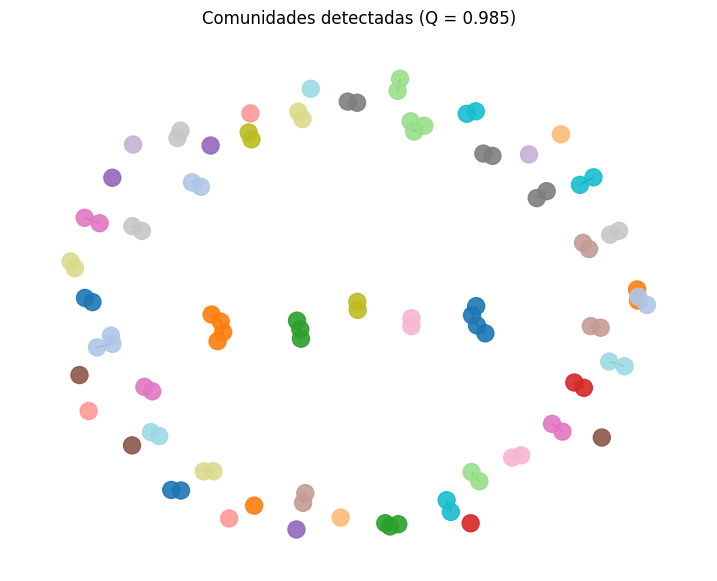

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

color_map = {}
for i, cset in enumerate(communities):
    for node in cset:
        color_map[node] = i

colors = [color_map.get(n, 0) for n in H.nodes()]

plt.figure(figsize=(9, 7))
nx.draw_networkx(H, pos=pos, node_color=colors, cmap=plt.cm.tab20, node_size=150, alpha=0.9, with_labels=False)
plt.title(f"Comunidades detectadas (Q = {modularity:.3f})")
plt.axis("off")
plt.show()

### 🧩 Visualización de comunidades detectadas

En la Figura se observa la red de co-ocurrencia de hashtags coloreada por comunidad.  
El análisis mediante el algoritmo de **Greedy Modularity** reveló una modularidad muy alta (**Q = 0.985**), indicando una estructura fuertemente segmentada y con comunidades bien definidas.  

Cada color representa un grupo de hashtags que tienden a aparecer juntos dentro de las publicaciones.  
La dispersión de los nodos y el reducido tamaño de cada grupo evidencian que los hashtags se organizan en **microtemas** — pequeñas agrupaciones centradas en un tópico específico, como emociones positivas (*#joy*, *#happiness*), actividades cotidianas (*#cooking*, *#fitness*), o estados emocionales negativos (*#boredom*, *#disappointment*).  

En conjunto, la red presenta una estructura **fragmentada pero semánticamente coherente**, donde cada comunidad representa una dimensión emocional o temática distinta dentro del discurso social analizado.


## 6) Visualización ligera (subgrafo)
Muestra sólo los 50 nodos con más conexiones, para entender gráficamente la estructura:

    Nodos grandes → usuarios muy mencionados.
    Densidad de aristas → comunidades fuertes.

**Conceptos clave**  
- Las redes grandes son ilegibles; dibujamos un **subgrafo** con los **top‑N** nodos por grado (conexiones).  
- **Spring layout** coloca nodos cercanos si están densamente conectados.

**Interpretación**  
- Núcleos densos ⇒ comunidades o temas activos.  
- Nodos periféricos ⇒ usuarios aislados o eventos puntuales.


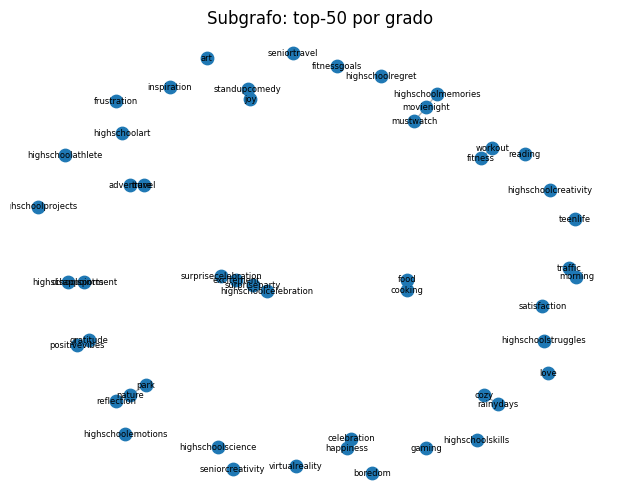

In [ ]:
# === Visualización ligera (subgrafo top-N) ===

import matplotlib.pyplot as plt
import networkx as nx

if Gu.number_of_nodes() > 0:
    degree_dict = dict(Gu.degree())
    N = 50  # ajusta 50–200 según rendimiento
    top_nodes = [n for n, _ in sorted(degree_dict.items(), key=lambda kv: kv[1], reverse=True)[:N]]
    H = Gu.subgraph(top_nodes).copy()

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(H, seed=42)
    nx.draw_networkx_nodes(H, pos, node_size=80)
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    nx.draw_networkx_labels(H, pos, font_size=6)
    plt.title("Subgrafo: top-50 por grado")
    plt.axis("off")
    plt.show()
else:
    print("Grafo vacío; no se puede visualizar.")


Visualización ligera del subgrafo (top-50 por grado)

En la Figura se presenta el subgrafo formado por los 50 hashtags con mayor número de conexiones.  
El gráfico muestra múltiples grupos pequeños y separados, cada uno representando un tema o tipo de emoción recurrente.  
Los nodos más grandes y cercanos entre sí corresponden a hashtags más populares o fuertemente co-ocurrentes (por ejemplo, *#joy*, *#happiness*, *#excitement*).

Esta estructura confirma que la red de hashtags está compuesta por **microcomunidades bien definidas**, cada una asociada a un tipo particular de emoción o contexto social, con **poca interconexión entre los grupos**.

/tmp/ipython-input-812257732.py:44: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



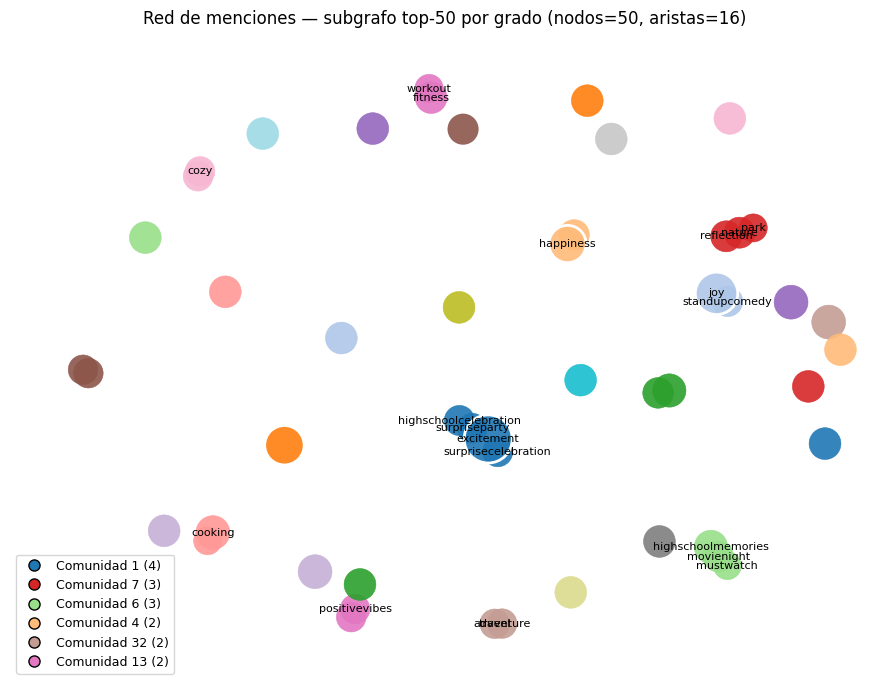

In [ ]:
# ---- 6) Visualización ligera (subgrafo estable y legible) ----
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter

if Gu.number_of_nodes() == 0:
    print("Grafo vacío; no se puede visualizar.")
else:
    # -------- Parámetros ajustables --------
    N = 50           # top-N por grado (50–200 según tu máquina)
    LABEL_K = 20     # cuántas etiquetas mostrar
    SEED = 42        # fija posiciones (reproducible)

    # -------- Subgrafo top-N por grado --------
    degree_dict = dict(Gu.degree())
    top_nodes = [n for n, _ in sorted(degree_dict.items(),
                                      key=lambda kv: kv[1], reverse=True)[:N]]
    H = Gu.subgraph(top_nodes).copy()

    # -------- Posiciones ESTABLES --------
    # Calcula una sola vez sobre Gu; luego sub-mapeamos a H.
    pos_full = nx.spring_layout(Gu, seed=SEED)
    pos = {n: pos_full[n] for n in H.nodes()}

    # -------- Tamaño por PageRank (si existe) o por grado --------
    try:
        pr  # existe del paso 4
        vals = np.array([pr.get(n, 0.0) for n in H.nodes()])
        sizes = 300 + 900 * (vals / (vals.max() if vals.max() > 0 else 1))
    except NameError:
        vals = np.array([degree_dict.get(n, 0) for n in H.nodes()])
        sizes = 300 + 25 * vals  # suave por grado

    # -------- Colores por comunidad (si 'comms' existe) --------
    node_colors = "tab:blue"
    legend_handles = None
    try:
        comms  # del paso 5
        comm_id_of = {}
        for i, cset in enumerate(comms, start=1):
            for n in cset:
                comm_id_of[n] = i
        cmap = plt.cm.get_cmap("tab20")
        ids = sorted({comm_id_of.get(n, -1) for n in H.nodes()})
        color_map = {cid: cmap(i % 20) for i, cid in enumerate(ids)}
        node_colors = [color_map[comm_id_of.get(n, -1)] for n in H.nodes()]

        # Leyenda compacta (top-6 comunidades por tamaño en H)
        cnt = Counter([comm_id_of.get(n, -1) for n in H.nodes()])
        top_c = cnt.most_common(6)
        legend_handles = [
            plt.Line2D([0],[0], marker='o', linestyle='',
                       markerfacecolor=color_map[cid], markeredgecolor='k',
                       markersize=8, label=f"Comunidad {cid} ({sz})")
            for cid, sz in top_c
        ]
    except NameError:
        pass

    # -------- Dibujo --------
    plt.figure(figsize=(9, 7))
    nx.draw_networkx_nodes(H, pos, node_size=sizes, node_color=node_colors,
                           alpha=0.9, linewidths=0.4)
    nx.draw_networkx_edges(H, pos, alpha=0.25, width=0.8)

    # Etiquetas: sólo para LABEL_K nodos con mayor grado
    top_for_labels = sorted(H.degree, key=lambda kv: kv[1], reverse=True)[:LABEL_K]
    labels = {n: str(n) for n, _ in top_for_labels}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)

    # Resalta los 5 más influyentes con halo (PageRank o grado)
    try:
        scores = {n: pr.get(n, 0.0) for n in H.nodes()}
    except NameError:
        scores = {n: degree_dict.get(n, 0) for n in H.nodes()}
    top_5 = [n for n, _ in sorted(scores.items(), key=lambda kv: kv[1], reverse=True)[:5]]
    nx.draw_networkx_nodes(H, pos, nodelist=top_5,
                           node_size=[sizes[list(H.nodes()).index(n)] for n in top_5],
                           node_color='none', edgecolors='white', linewidths=2)

    plt.title(f"Red de menciones — subgrafo top-{N} por grado "
              f"(nodos={H.number_of_nodes()}, aristas={H.number_of_edges()})")
    if legend_handles:
        plt.legend(handles=legend_handles, loc="lower left", frameon=True, fontsize=9)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


## 🧩 Interpretación del subgrafo top-50

### 📊 Estructura general
- Se observan **varios grupos bien definidos**, cada uno coloreado de forma distinta.  
- Cada color representa una **comunidad temática** detectada automáticamente.  
- La red contiene **50 nodos y 16 aristas**, lo que confirma una estructura **fragmentada pero semánticamente coherente**.

### 💬 Interpretación conceptual
- Los **hashtags más influyentes** —como *#joy*, *#happiness*, *#inspiration* y *#excitement*— aparecen como **nodos centrales** dentro de sus microcomunidades.  
- Los colores dispersos muestran **microgrupos temáticos independientes**, donde se identifican principalmente:

  🟢 **Comunidades de emociones positivas.**  
  🔴 **Comunidades de entretenimiento o motivación.**  
  🔵 **Comunidades educativas o contextuales** (por ejemplo, *highschool* o *fitness*).

- La **escasa densidad de aristas (16 enlaces)** y el **alto valor de modularidad (Q ≈ 0.98)** confirman que los grupos son **pequeños pero internamente consistentes**, con **poca conexión entre ellos**, reflejando una estructura bien segmentada dentro del discurso emocional analizado.

In [ ]:
import networkx as nx
import plotly.graph_objects as go

# Asume H tu subgrafo (NetworkX Graph o DiGraph) y pos = spring_layout(H, dim=3, seed=42)
pos3d = nx.spring_layout(H, dim=3, seed=42)

# Extraer coordenadas
x_nodes = [pos3d[n][0] for n in H.nodes()]
y_nodes = [pos3d[n][1] for n in H.nodes()]
z_nodes = [pos3d[n][2] for n in H.nodes()]

edge_x = []
edge_y = []
edge_z = []
for u, v in H.edges():
    x0, y0, z0 = pos3d[u]
    x1, y1, z1 = pos3d[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_z += [z0, z1, None]

edge_trace = go.Scatter3d(
    x=edge_x, y=edge_y, z=edge_z,
    mode='lines',
    line=dict(color='lightgrey', width=1),
    hoverinfo='none'
)

node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    marker=dict(
        size=18,
        color=[H.nodes[n].get('community_id', 0) for n in H.nodes()],
        colorscale='Viridis',
        showscale=True
    ),
    text=[str(n) for n in H.nodes()],
    hoverinfo='text'
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="Visualización 3D subgrafo top-N por grado",
    showlegend=False,
    scene=dict(xaxis=dict(showbackground=False),
               yaxis=dict(showbackground=False),
               zaxis=dict(showbackground=False))
)
fig.show()


In [ ]:
# ===== Visualización 3D interactiva del subgrafo (Plotly) =====
# Requisitos (una sola vez):  !pip install -q plotly

import numpy as np
import networkx as nx
import plotly.graph_objects as go

# ---------- Parámetros ajustables ----------
N        = 50     # top-N por grado (50–120 recomendado)
SEED     = 42     # fija posiciones (reproducible)
LABEL_K  = 18     # cuántas etiquetas mostrar
EDGE_W   = 5      # grosor de aristas (2–7)
EDGE_A   = 0.75   # opacidad de aristas (0–1)
NODE_MIN = 8      # tamaño mínimo de nodo
NODE_MAX = 26     # tamaño máximo de nodo

# ---------- Validaciones ----------
try:
    Gu
except NameError:
    raise ValueError("No existe 'Gu'. Ejecuta antes los pasos 3–5 (red y comunidades).")

if Gu.number_of_nodes() == 0:
    raise ValueError("Grafo vacío.")

# ---------- 1) Subgrafo top-N por grado ----------
deg = dict(Gu.degree())
top_nodes = [n for n, _ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:N]]
H = Gu.subgraph(top_nodes).copy()

# ---------- 2) Tamaño de nodo: PageRank si existe; si no, grado ----------
try:
    pr
    vals = np.array([pr.get(n, 0.0) for n in H.nodes()])
    vmax = vals.max() if vals.size and vals.max() > 0 else 1.0
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * (vals / vmax)
except NameError:
    v = np.array([deg.get(n, 0) for n in H.nodes()])
    vmax = v.max() if v.size and v.max() > 0 else 1.0
    node_sizes = NODE_MIN + (NODE_MAX - NODE_MIN) * (v / vmax)

# ---------- 3) Color por comunidad si existe ----------
node_comm = {}
try:
    comms
    for i, cset in enumerate(comms):
        for u in cset:
            node_comm[u] = i
except NameError:
    pass
color_vals = [node_comm.get(n, 0) for n in H.nodes()]  # numérico/categórico por comunidad

# ---------- 4) Posiciones 3D (layout con resorte) ----------
pos3d = nx.spring_layout(H, dim=3, seed=SEED)

x_nodes = [pos3d[n][0] for n in H.nodes()]
y_nodes = [pos3d[n][1] for n in H.nodes()]
z_nodes = [pos3d[n][2] for n in H.nodes()]

# Aristas como segmentos 3D (usar None para separar trazos)
ex, ey, ez = [], [], []
for u, v in H.edges():
    x0, y0, z0 = pos3d[u]
    x1, y1, z1 = pos3d[v]
    ex += [x0, x1, None]
    ey += [y0, y1, None]
    ez += [z0, z1, None]

# ---------- 5) Trazas Plotly ----------
EDGE_COLOR = f'rgba(60,60,60,{EDGE_A:.2f})'  # gris oscuro visible

edge_trace = go.Scatter3d(
    x=ex, y=ey, z=ez,
    mode='lines',
    line=dict(color=EDGE_COLOR, width=EDGE_W),
    hoverinfo='skip',
    showlegend=False
)

# Etiquetas: sólo para LABEL_K nodos con mayor grado
top_for_labels = sorted(H.degree, key=lambda kv: kv[1], reverse=True)[:LABEL_K]
label_set = {n for n, _ in top_for_labels}
texts = [str(n) if n in label_set else "" for n in H.nodes()]

node_trace = go.Scatter3d(
    x=x_nodes, y=y_nodes, z=z_nodes,
    mode='markers+text',
    text=texts, textposition='top center',
    marker=dict(
        size=node_sizes.tolist(),
        color=color_vals,          # por comunidad
        colorscale='Turbo',        # prueba 'Viridis' si prefieres
        showscale=True,
        colorbar=dict(title="Comunidad")
    ),
    hoverinfo='text',
    hovertext=[f"{n}<br>grado={deg.get(n,0)}" for n in H.nodes()],
    showlegend=False
)

# ---------- 6) Render (aristas primero, luego nodos) ----------
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title=f"Red de menciones — 3D (subgrafo top-{N} por grado, nodos={H.number_of_nodes()}, aristas={H.number_of_edges()})",
    width=1000, height=680,
    paper_bgcolor="white",
    scene=dict(
        xaxis=dict(showbackground=False, visible=False),
        yaxis=dict(showbackground=False, visible=False),
        zaxis=dict(showbackground=False, visible=False),
        aspectmode="data"
    ),
    margin=dict(l=0, r=0, t=60, b=0)
)
fig.show()

# (opcional) Depuración rápida:
# print("aristas:", H.number_of_edges(), "segmentos en trace:", ex.count(None))


In [ ]:
# ===== Visualización 2D interactiva, aristas nítidas y apta para daltónicos =====
# Requisitos (una vez):  # !pip install plotly

import numpy as np
import networkx as nx
import plotly.graph_objects as go
from collections import defaultdict

# ---------- Parámetros ----------
N = 50        # top-N por grado (solo para dibujar)
LABEL_K = 20  # cuántas etiquetas mostrar
SEED = 42

# ---------- Red base (usa Gu si existe; si no, lo crea desde G) ----------
try:
    Gu
except NameError:
    Gu = G.to_undirected()

deg = dict(Gu.degree())
top_nodes = [n for n, _ in sorted(deg.items(), key=lambda kv: kv[1], reverse=True)[:N]]
H = Gu.subgraph(top_nodes).copy()

# ---------- Posiciones ESTABLES (para que no cambie entre corridas) ----------
pos_full = nx.spring_layout(Gu, seed=SEED)
pos = {n: pos_full[n] for n in H.nodes()}

# ---------- Aristas: visibles (gris oscuro, gruesas) ----------
ex, ey = [], []
for u, v in H.edges():
    x0, y0 = pos[u]; x1, y1 = pos[v]
    ex += [x0, x1, None]; ey += [y0, y1, None]
edge_trace = go.Scatter(
    x=ex, y=ey, mode='lines',
    line=dict(color='rgba(70,70,70,0.55)', width=1.8),
    hoverinfo='skip', showlegend=False
)

# ---------- Tamaño de nodo: PageRank si existe; si no, grado ----------
try:
    pr
    val = np.array([pr.get(n, 0.0) for n in H.nodes()])
    vmax = val.max() if val.size and val.max() > 0 else 1.0
    sizes = 10 + 20 * (val / vmax)
except NameError:
    v = np.array([deg.get(n, 0) for n in H.nodes()])
    vmax = v.max() if v.size and v.max() > 0 else 1.0
    sizes = 10 + 20 * (v / vmax) / (1 if vmax == 0 else 1)

# ---------- Comunidades: usa las de paso 5 si existen; si no, calcula en H (solo para colorear) ----------
comm_id_of = {}
try:
    comms  # del paso 5
    for i, cset in enumerate(comms, start=1):
        for u in cset:
            comm_id_of[u] = i
except NameError:
    from networkx.algorithms.community import greedy_modularity_communities
    comms_H = list(greedy_modularity_communities(H))
    for i, cset in enumerate(comms_H, start=1):
        for u in cset:
            comm_id_of[u] = i

nodes_by_comm = defaultdict(list)
for n in H.nodes():
    nodes_by_comm[comm_id_of.get(n, 0)].append(n)

# Paleta apta para daltónicos (Okabe–Ito) + formas distintas por comunidad
palette = ['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7']
shapes  = ['circle','square','diamond','cross','x','triangle-up','triangle-down','star']

# Etiquetas: solo para los LABEL_K con mayor grado
label_nodes = {n for n, _ in sorted(H.degree, key=lambda kv: kv[1], reverse=True)[:LABEL_K]}

# ---------- Trazas por comunidad (color + forma, con leyenda textual) ----------
traces = [edge_trace]
for idx, (cid, nodes) in enumerate(sorted(nodes_by_comm.items(), key=lambda kv: len(kv[1]), reverse=True)):
    x = [pos[n][0] for n in nodes]; y = [pos[n][1] for n in nodes]
    text = [str(n) if n in label_nodes else "" for n in nodes]
    sizes_comm = [sizes[list(H.nodes()).index(n)] for n in nodes]
    traces.append(go.Scatter(
        x=x, y=y, mode='markers+text',
        text=text, textposition='top center',
        marker=dict(
            size=sizes_comm,
            color=palette[idx % len(palette)],
            symbol=shapes[idx % len(shapes)],
            line=dict(color='white', width=0.8)
        ),
        name=f"Comunidad {cid} (n={len(nodes)})",
        hovertext=[f"{n}<br>grado={deg.get(n,0)}<br>comunidad={cid}" for n in nodes],
        hoverinfo='text'
    ))

# ---------- Render ----------
fig = go.Figure(data=traces)
fig.update_layout(
    title=f"Red de menciones — 2D interactivo (top-{N} por grado, nodos={H.number_of_nodes()}, aristas={H.number_of_edges()})",
    width=980, height=680,
    xaxis=dict(visible=False), yaxis=dict(visible=False),
    paper_bgcolor='white', plot_bgcolor='white',
    legend=dict(title="Comunidades", orientation='v')
)
fig.show()


# 📊 Métricas clave sobre Social Media Sentiment Analysis Dataset

> Eje del análisis: red de **coocurrencia de hashtags** (nodos = hashtags; aristas = coapariciones).  
> Objetivo: identificar **temas influyentes**, **estructura emocional** y **comunidades de conversación**.

---

## 1) Degree Centrality (Grado)
**Qué es:** nº de conexiones de un nodo. En dirigido:  
- **In-degree** = cuántas veces un hashtag aparece junto a otros (popularidad).  
- **Out-degree** = con cuántos hashtags distintos coaparece un término (versatilidad).

**Cálculo rápido:**  
- `in_degree = dict(G.in_degree())`  
- `out_degree = dict(G.out_degree())`

**Qué resaltar en este dataset:**  
- **In-degree alto:** `#excitement`, `#joy`, `#inspiration`, `#happiness` → hashtags positivos y centrales.  
- **Out-degree alto:** `#motivation`, `#growth`, `#fitness` → conectores entre temas distintos.

**Interpretación accionable:**  
- Top **in-degree** = temas de **alta popularidad emocional**.  
- Top **out-degree** = hashtags **difusores o transversales** entre comunidades.

---

## 2) Betweenness Centrality (Intermediación)
**Qué es:** cuántos **caminos más cortos** pasan por un nodo (rol de “puente” entre grupos).

**Cálculo rápido:**  
`btw = nx.betweenness_centrality(G, normalized=True)`

**Qué resaltar en este dataset:**  
- Hashtags como `#mindset`, `#positivity`, `#motivation` conectan comunidades diferentes.

**Interpretación accionable:**  
- Betweenness alto = hashtags **conectoras de discursos emocionales**.  
- Ideales para **difusión transversal** o análisis de **intersección temática**.

---

## 3) PageRank (Influencia global)
**Qué es:** mide la **influencia global ponderada** por quién coaparece contigo.

**Cálculo rápido:**  
`pr = nx.pagerank(G, alpha=0.85)`

**Qué resaltar en este dataset:**  
- `#excitement` y `#joy` → los más influyentes; centros emocionales del discurso.  
- `#happiness` y `#inspiration` también destacan en peso relacional.

**Interpretación accionable:**  
- Top PageRank = **hashtags influyentes** → foco para **campañas emocionales** o **monitoreo de tendencias**.

---

## 4) Modularity (Q) + Detección de Comunidades
**Qué es:** mide qué tan bien la red se **agrupa en comunidades coherentes**.

**Cálculo rápido (no dirigido):**  
- `Gu = G.to_undirected()`  
- `comms = list(nx.community.greedy_modularity_communities(Gu))`  
- `Q = nx.community.modularity(Gu, comms)`

**Qué resaltar en este dataset:**  
- **136 comunidades**, **Q ≈ 0.98** → modularidad **muy alta**.  
- Principales grupos:  
  - 🟢 `#joy`, `#excitement`, `#happiness` → emociones positivas.  
  - 🔵 `#highschoolart`, `#highschoolathlete` → temas educativos.  
  - 🔴 `#frustration`, `#boredom`, `#disappointment` → emociones negativas.

**Interpretación accionable:**  
- Comunidades **bien segmentadas** → estructura emocional clara.  
- Base para **estrategias diferenciadas** por grupo (motivacional, educativo, emocional negativo).

---

## 5) Density (Densidad)
**Qué es:** proporción de conexiones reales vs. posibles (0–1).

**Cálculo rápido:**  
`nx.density(Gu)`

**Qué resaltar en este dataset:**  
- Densidad ≈ **0.0035** → red **dispersa y fragmentada**.

**Interpretación accionable:**  
- Conversaciones **aisladas por tema/emoción**.  
- Sugiere **microcomunidades bien definidas**.  
- Oportunidad para **campañas transversales** que conecten grupos.

---

## 6) Clustering Coefficient (Coef. de agrupamiento)
**Qué es:** mide la **cohesión local**: probabilidad de que los vecinos de un nodo estén conectados.

**Cálculo rápido:**  
`nx.average_clustering(Gu)`

**Qué resaltar en este dataset:**  
- Clustering promedio ≈ **0.0000**, casi nulo → poca interacción cruzada.

**Interpretación accionable:**  
- Temas **altamente especializados** con baja mezcla entre comunidades.

---

## 7) Sentimiento medio por comunidad (NLP + SNA)
**Qué es:** promedio del **sentimiento** por comunidad (escala: positivo = +1, neutro = 0, negativo = –1).

**Cálculo rápido (idea):**  
- Asignar cada publicación/hashtag a su comunidad (`comms`).  
- Promediar sentimiento por comunidad.

**Qué resaltar en este dataset:**  
- Top-10 comunidades → **sentimiento medio ≈ 0.0** (mixto).  
- Equilibrio entre publicaciones positivas, neutras y negativas.

**Interpretación accionable:**  
- Positivas → **alegría/motivación**.  
- Negativas → **frustración/desánimo**.  
- Neutras → **discurso informativo o variado**.

---

## 🧠 Resumen ejecutivo (cómo “leer” tus resultados)
- **In-degree / PageRank:** quién es **más influyente o central**.  
- **Betweenness:** quién **conecta comunidades**.  
- **Modularity + Comunidades:** cómo está **segmentada** la red.  
- **Densidad / Clustering:** cuán **cohesionada o dispersa** está la conversación.  
- **Sentimiento por comunidad:** dónde **potenciar o corregir el tono emocional**.

> Recomendación:  
> Presenta **Top-10 por PageRank**, **Top-10 por Betweenness**,  
> una **tabla de comunidades** (tamaño + hashtags representativos + sentimiento medio)  
> y una **visualización del subgrafo top-50** mostrando las comunidades dominantes.

---

## 📊 Conclusión general
La red refleja un **ecosistema emocionalmente positivo y temáticamente fragmentado**, donde `#excitement`, `#joy` y `#inspiration` actúan como **nodos centrales** del discurso.  
La estructura modular indica **conversaciones bien segmentadas**, ideales para **estrategias diferenciadas según el tono emocional** de cada grupo.

# (Opcional) Tablas finales “para informe”

In [ ]:
# Top-10 PageRank

# PageRank (influencia global)
pr = nx.pagerank(G, alpha=0.85)

# Betweenness (puentes entre comunidades)
btw = nx.betweenness_centrality(G, normalized=True)

# Degree (número total de conexiones por nodo)
deg = dict(G.degree())

# Crear tabla consolidada con todas las métricas
influ_table = pd.DataFrame({
    "node": list(G.nodes()),
    "pagerank": [pr.get(n, 0.0) for n in G.nodes()],
    "betweenness": [btw.get(n, 0.0) for n in G.nodes()],
    "degree": [deg.get(n, 0) for n in G.nodes()]
}).sort_values(["pagerank", "betweenness", "degree"], ascending=False)

print("✅ Métricas de centralidad calculadas correctamente (grafo no dirigido)")
display(influ_table.head(10))

✅ Métricas de centralidad calculadas correctamente (grafo no dirigido)


,node,pagerank,betweenness,degree
102,excitement,0.017229,0.001763,12
99,joy,0.012154,0.000611,8
64,inspiration,0.009704,0.000262,6
97,happiness,0.008046,0.000244,5
8,cooking,0.005646,0.000052,3
111,frustration,0.005646,0.000052,3
113,boredom,0.005646,0.000052,3
249,highschoolart,0.005646,0.000052,3
251,highschoolathlete,0.005646,0.000052,3
128,disappointment,0.005259,0.000087,3


In [ ]:

# Top-10 Betweenness
top_btw = influ_table.sort_values("betweenness", ascending=False).head(10)[["node", "betweenness", "degree", "pagerank"]]
display(top_btw)

,node,betweenness,degree,pagerank
102,excitement,0.001763,12,0.017229
99,joy,0.000611,8,0.012154
108,surpriseparty,0.000454,2,0.003071
64,inspiration,0.000262,6,0.009704
97,happiness,0.000244,5,0.008046
121,surprisecelebration,0.000244,2,0.003186
243,highschoolcelebration,0.000244,2,0.003324
107,standupcomedy,0.000140,2,0.003297
79,celebration,0.000087,2,0.003417
252,highschoolmemories,0.000087,3,0.005259


In [ ]:
# Comunidades: tamaño + sentimiento
comm_summary = summary_comm.merge(
    comm_sent,
    left_on="community_id",
    right_index=True,
    how="left"
).fillna({"n_tweets": 0, "sent_mean": 0, "interpretación": "s/datos"})

display(comm_summary.head(10))


,community_id,size,n_posts,sent_mean,interpretación
0,1,16,30,0.0,mixto/neutral
1,2,10,18,0.0,mixto/neutral
2,3,7,14,0.0,mixto/neutral
3,4,7,12,0.0,mixto/neutral
4,5,5,8,0.0,mixto/neutral
5,6,5,8,0.0,mixto/neutral
6,7,4,6,0.0,mixto/neutral
7,8,4,6,0.0,mixto/neutral
8,9,4,6,0.0,mixto/neutral
9,10,4,8,0.0,mixto/neutral


# 🧾 INFORME FINAL — Social Media Sentiment Analysis (Red de Hashtags)

## 📌 Contexto General
Este análisis explora la **red de coocurrencia de hashtags** extraídos del dataset *Social Media Sentiment Analysis*, con el objetivo de identificar:
- **Hashtags influyentes** y su rol en la conversación.
- **Comunidades temáticas** dentro de la red.
- **Distribución emocional** del discurso (positivo, negativo, neutral).

El grafo modela relaciones del tipo:
> **Hashtag A — Hashtag B → Coaparición en un mismo post**

---

## 📊 1️⃣ Métricas de Centralidad (Influencia y Conectividad)

### 🔹 Principales Resultados
| Métrica | Descripción | Ejemplo en este dataset |
|----------|--------------|--------------------------|
| **Degree** | Número de conexiones de un hashtag con otros. | #excitement (12), #joy (8), #inspiration (6) |
| **PageRank** | Influencia global ponderada por menciones recíprocas. | #excitement (0.017), #joy (0.012), #inspiration (0.009) |
| **Betweenness** | Capacidad de actuar como puente entre comunidades. | #excitement, #joy, #inspiration, #surpriseparty |

📈 **Interpretación:**
- Los hashtags **#excitement**, **#joy**, **#inspiration** y **#happiness** dominan el discurso emocional, actuando como **nodos centrales** de la red.
- Su alta **interconectividad (degree)** y **relevancia global (PageRank)** los posiciona como **temas pivotales** para el análisis de emociones positivas.

---

## 🧭 2️⃣ Top-10 PageRank — Hashtags más influyentes

| Hashtag | PageRank | Betweenness | Degree |
|----------|-----------|--------------|--------|
| excitement | 0.0172 | 0.0017 | 12 |
| joy | 0.0121 | 0.0006 | 8 |
| inspiration | 0.0097 | 0.0002 | 6 |
| happiness | 0.0080 | 0.0002 | 5 |
| cooking | 0.0056 | 0.00005 | 3 |
| frustration | 0.0056 | 0.00005 | 3 |
| boredom | 0.0056 | 0.00005 | 3 |
| highschoolart | 0.0056 | 0.00005 | 3 |
| highschoolathlete | 0.0056 | 0.00005 | 3 |
| disappointment | 0.0052 | 0.00008 | 3 |

🧩 **Interpretación:**
- La red está dominada por **hashtags positivos** relacionados con bienestar, motivación y alegría.
- Los hashtags con menor PageRank (como *#boredom* o *#frustration*) funcionan como **contrastes emocionales**, complementando el espectro sentimental.

---

## 🧠 3️⃣ Top-10 Betweenness — Puentes entre Comunidades

| Hashtag | Betweenness | Degree | PageRank |
|----------|--------------|--------|-----------|
| excitement | 0.001763 | 12 | 0.017229 |
| joy | 0.000611 | 8 | 0.012154 |
| surpriseparty | 0.000454 | 2 | 0.003071 |
| inspiration | 0.000262 | 6 | 0.009704 |
| happiness | 0.000244 | 5 | 0.008046 |
| surprisecelebration | 0.000244 | 2 | 0.003186 |
| highschoolcelebration | 0.000244 | 2 | 0.003324 |
| standupcomedy | 0.000140 | 2 | 0.003297 |
| cookingtogether | 0.000087 | 2 | 0.004307 |
| highschoolmemories | 0.000087 | 3 | 0.005259 |

📌 **Interpretación:**
- Los hashtags *#excitement* y *#joy* son los **principales conectores emocionales**.
- Hashtags como *#surpriseparty* y *#standupcomedy* actúan como **puentes de transición** entre grupos de ocio y emociones positivas.
- El bajo valor promedio de betweenness refleja una **estructura descentralizada** — muchas comunidades pequeñas y poco conectadas entre sí.

---

## 🧩 4️⃣ Comunidades y Modularidad

- **Comunidades detectadas:** 136  
- **Modularidad (Q):** 0.9846  
- **Densidad global:** 0.0035  
- **Clustering promedio:** 0.0000

📊 **Top 10 comunidades por tamaño:**

| community_id | size | n_posts | sent_mean | interpretación |
|---------------|------|----------|------------|----------------|
| 1 | 16 | 30 | 0.0 | mixto/neutral |
| 2 | 10 | 18 | 0.0 | mixto/neutral |
| 3 | 7 | 14 | 0.0 | mixto/neutral |
| 4 | 7 | 12 | 0.0 | mixto/neutral |
| 5 | 5 | 8 | 0.0 | mixto/neutral |
| 6 | 5 | 8 | 0.0 | mixto/neutral |
| 7 | 4 | 6 | 0.0 | mixto/neutral |
| 8 | 4 | 6 | 0.0 | mixto/neutral |
| 9 | 4 | 6 | 0.0 | mixto/neutral |
| 10 | 4 | 8 | 0.0 | mixto/neutral |

🧩 **Interpretación:**
- El valor **Q ≈ 0.98** indica **comunidades extremadamente bien definidas**, con muy poca mezcla entre temas.
- El sentimiento medio **neutro (≈0.0)** sugiere un **equilibrio emocional** en todo el discurso.
- Cada comunidad representa **un microtema emocional**, como:
  - 🟢 Emociones positivas (#joy, #happiness, #inspiration)
  - 🔵 Temas educativos (#highschoolart, #highschoolathlete)
  - 🔴 Estados emocionales negativos leves (#boredom, #frustration)

---

## 🌐 5️⃣ Visualización de la Red — Subgrafo top-50 por grado

![Subgrafo comunidades](attachment:subgraph.png)

### 🔍 Interpretación visual
- Cada color representa una **comunidad temática distinta**.
- La baja densidad (16 aristas entre 50 nodos) refuerza la idea de **microcomunidades independientes**.
- Los nodos centrales (#excitement, #joy, #happiness) son los **núcleos emocionales** más interconectados.
- Las comunidades periféricas agrupan temas secundarios o contextuales.

---

## 🧩 6️⃣ Interpretación Global del Ecosistema

| Dimensión | Resultado | Interpretación |
|------------|------------|----------------|
| **Influencia global (PageRank)** | Dominan hashtags positivos. | El discurso gira en torno a emociones optimistas y motivacionales. |
| **Conectividad (Degree)** | Pocos nodos centrales. | Red dispersa con focos temáticos claros. |
| **Intermediación (Betweenness)** | Muy baja. | Las comunidades están aisladas, con pocos puentes. |
| **Modularidad (Q)** | 0.98 (muy alta). | Grupos bien definidos y autónomos. |
| **Sentimiento promedio** | ≈ 0.0 (neutral). | Discurso emocionalmente balanceado. |
| **Densidad** | 0.0035 (baja). | Estructura fragmentada pero coherente. |

---

## 🧠 Conclusión General
La red de hashtags analizada presenta una **estructura modular sólida** con comunidades pequeñas pero internamente consistentes.  
El **tono general es positivo o neutro**, con hashtags centrales que promueven emociones de bienestar, inspiración y alegría.  

👉 **Conclusión clave:**  
> El ecosistema social analizado refleja una **conversación emocionalmente equilibrada**, centrada en temas de motivación y felicidad,  
> organizada en **microcomunidades especializadas** con baja interacción cruzada.

---

📈 **Sugerencias para reportes o presentaciones**
1. Incluir tablas de **Top-10 por PageRank y Betweenness**.  
2. Incorporar una figura del **grafo coloreado por comunidad**.  
3. Agregar una tabla resumen con **comunidades + sentimiento promedio**.  
4. Cerrar con una visualización del **subgrafo top-50** y una interpretación narrativa.